In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [36]:
traintransform=  transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
        ])

testtransform= transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [37]:
root= '../Data/CATS_DOGS/'

traindata=datasets.ImageFolder(os.path.join(root,'train'),transform=traintransform)
testdata= datasets.ImageFolder(os.path.join(root,'test'),transform=testtransform)
torch.manual_seed(42)
trainloader=DataLoader(traindata,batch_size=10,shuffle=True)
testloader=DataLoader(testdata,batch_size=10)
classnames=traindata.classes
classnames

['CAT', 'DOG']

In [38]:
len(traindata)

18743

In [39]:
len(testdata)

6251

# grabbing a batch of images 

In [40]:
for images,labels in trainloader:
    break
images.shape


torch.Size([10, 3, 224, 224])

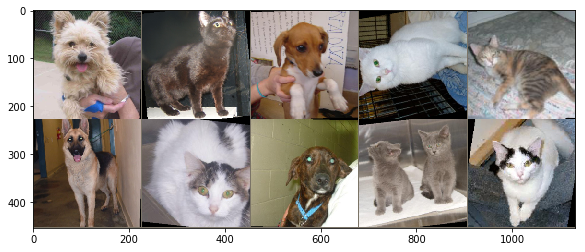

In [41]:
im= make_grid(images,nrow=5)

#inverse normalize to display original images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv=inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# defining model

In [43]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,3,1)
        self.conv2=nn.Conv2d(6,16,3,1)
        self.fc1=nn.Linear(54*54*16,120)  #(((224-2)/2)-2)/2= 54.5 -->54*54 
        self.fc2= nn.Linear(120,84)
        self.fc3= nn.Linear(84,2)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,54*54*16)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=self.fc3(X)
        
        return F.log_softmax(X,dim=1)

In [45]:
torch.manual_seed(101)
cnnmodel=ConvNet()
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(cnnmodel.parameters(),lr=0.001)
cnnmodel

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [48]:
for param in cnnmodel.parameters():
    print(param.numel())

162
6
864
16
5598720
120
10080
84
168
2


In [51]:
import time
starttime=time.time()

epochs=3
#limits on num of batches
maxtrnbatch=800 #batch has 10 imgs-->8000imgs
maxtstbatch=300 #3000 imgs

for i in range(epochs):
    for b,(X_train,y_train) in enumerate(trainloader):
        #optional limit no of batches
        if b==maxtrnbatch:
            break
        b+=1
        y_pred=cnnmodel(X_train)
        loss=criterion(y_pred,y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            print(f'epoch {i} loss {loss.item()}')
    #testset
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(testloader):
            
            if b==maxtstbatch:
                break
            y_val=cnnmodel(X_test)
            
        loss=criterion(y_val,y_test)
        


totaltime=time.time()-starttime
print(f'Totaltime{totaltime/60} mins')

epoch 0 loss 0.6771844625473022
epoch 0 loss 0.6487480401992798
epoch 0 loss 0.5756762623786926
epoch 0 loss 0.7485789060592651
epoch 1 loss 0.4927590787410736
epoch 1 loss 0.4720778465270996
epoch 1 loss 0.520542562007904
epoch 1 loss 0.674404501914978
epoch 2 loss 0.5955713987350464
epoch 2 loss 0.5627316236495972
epoch 2 loss 0.5864247679710388
epoch 2 loss 1.1021403074264526
Totaltime22.080727231502532 mins


In [52]:
torch.save(cnnmodel.state_dict(),'customcnnmodel.pt')

# using a pretrained model

using alexnet
here images have to be normalized the same way as how alexnet was trained bfore

In [54]:
Alexnet=models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\maade/.cache\torch\checkpoints\alexnet-owt-4df8aa71.pth
84.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


In [55]:
Alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [56]:
#freezing the pretrained weights n biases so we dont propagate thru those weights and biases 
for param in Alexnet.parameters():
    param.requires_grad=False

In [59]:
#modifying the classifier since the alexnet worked on 1000 categories which we dont want
#chnge the classifier unit alone in the above structure

torch.manual_seed(42)
Alexnet.classifier= nn.Sequential(nn.Linear(9216,1024),nn.ReLU(),nn.Dropout(0.5),nn.Linear(1024,2),nn.LogSoftmax(dim=1))
Alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_featur

In [60]:
for param in Alexnet.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [61]:
criterion=nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(Alexnet.classifier.parameters(),lr=0.001)  #only classifier params are optimized since thats only changed


In [63]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(trainloader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = Alexnet(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(testloader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = Alexnet(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 3.17440605  accuracy:  88.400%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.05652046  accuracy:  90.775%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.14692737  accuracy:  91.633%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.09021058  accuracy:  91.950%

Duration: 439 seconds


# using a single image to compare models

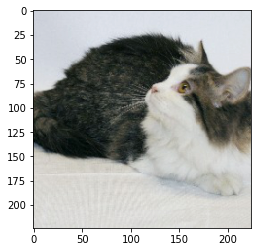

In [65]:
imageindex=2019
im=inv_normalize(testdata[imageindex][0])
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [71]:
cnnmodel.eval()
with torch.no_grad():
    newpred=cnnmodel(testdata[imageindex][0].view(1,3,224,224)).argmax()
classnames[newpred.item()]

'DOG'

In [72]:
Alexnet.eval()
with torch.no_grad():
    newpred=Alexnet(testdata[imageindex][0].view(1,3,224,224)).argmax()
classnames[newpred.item()]

'CAT'